<a href="https://colab.research.google.com/github/myazdani/sgd-linear-regression/blob/main/hidden_layer_weight_averaging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Averaging hidden-layer weights

[Ref](https://www.kaggle.com/code/glebbuzin/solving-sklearn-datasets-with-pytorch)

In [6]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import collections
import matplotlib.pyplot as plt
import plotly.express as px

## Data prep

In [14]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.07)
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)
px.scatter(x = X_train[:,0], y = X_train[:,1], color = [str(y) for y in y_train], width = 500, height = 400)

In [15]:
X_train_t = torch.from_numpy(X_train).to(torch.float32)
y_train_t = torch.from_numpy(y_train).to(torch.float32)
X_val_t = torch.from_numpy(X_val).to(torch.float32)
y_val_t = torch.from_numpy(y_val).to(torch.float32)


In [16]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## model def

In [17]:
def fetch_model(num_hidden_layers = 1, freeze_weights = False):
    '''
    
    '''
    hidden_layers = [("hidden0", nn.Linear(2, 30)), ("relu0", nn.ReLU())]
    for i in range(1, num_hidden_layers):
        hidden_layers.append(("hidden"+str(i), nn.Linear(30,30)))
        hidden_layers.append(("relu"+str(i), nn.ReLU()))
    hidden_layers.append(("clf", nn.Linear(30,1)))
    model = torch.nn.Sequential(
        collections.OrderedDict(
            hidden_layers
        )
    )
    if freeze_weights:
        for name, param in model.named_parameters():    
            if "clf" not in name:       
                param.requires_grad = False
    return model

In [18]:
torch.manual_seed(0)
unfrozen_model = fetch_model(num_hidden_layers=3)
torch.manual_seed(0)
frozen_model = fetch_model(num_hidden_layers=3, freeze_weights=True)

In [19]:
loss_function = nn.BCEWithLogitsLoss()

## training loop

In [20]:
def train(model, epochs):
    losses = []
    max_epochs = epochs
    stop_it = False
    optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
    for epoch in range(max_epochs):
        for it, (X_batch, y_batch) in enumerate(train_dataloader):
            optimizer.zero_grad()
            outp = model(X_batch)
            loss = loss_function(outp.flatten(), y_batch)
            loss.backward()
            losses.append(loss.detach().flatten()[0])
            optimizer.step()
            probabilities = torch.sigmoid(outp)
            preds = (probabilities>0.5).type(torch.long)
    return model, losses

In [21]:
%%time
unfrozen_model, unfrozen_losses = train(unfrozen_model, 20)


CPU times: user 2 s, sys: 27.8 ms, total: 2.03 s
Wall time: 2.22 s


In [22]:
%%time
frozen_model, frozen_losses = train(frozen_model, 20)

CPU times: user 1.64 s, sys: 6.55 ms, total: 1.64 s
Wall time: 1.65 s


In [23]:
def show_loss(losses):

    plt.plot(range(len(losses)), losses)
    plt.xlabel("Iteration")
    plt.ylabel("Loss")

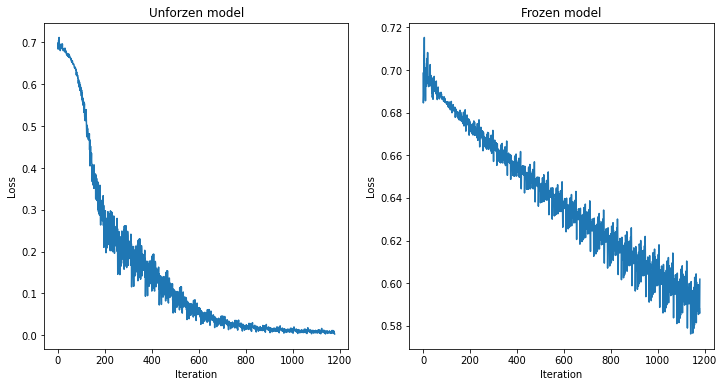

In [24]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
show_loss(unfrozen_losses)
plt.title("Unforzen model")
plt.subplot(1,2,2)
show_loss(frozen_losses)
plt.title("Frozen model");

## blending two frozen models

In [25]:
m1 = fetch_model(num_hidden_layers=3,freeze_weights=True)
m2 = fetch_model(num_hidden_layers=3,freeze_weights=True)

In [26]:
%%time
for _ in range(100):
    m1, losses_1 = train(m1, 1)
    m2, losses_2 = train(m2, 1)
    losses = torch.tensor([1/losses_1[-1], 1/losses_2[-2]])
    loss_weights = nn.functional.softmax(losses, dim = 0)
    
    for m1_params, m2_params in zip(m1.named_parameters(), m2.named_parameters()):
        m1_name, m1_param = m1_params
        m2_name, m2_param = m2_params
        if "clf" in m1_name:
            continue
        m1_param.data = loss_weights[0]*m1_param.data + loss_weights[1]*m2_param.data

    m2 = fetch_model(num_hidden_layers=3,freeze_weights=True)

CPU times: user 17.8 s, sys: 52.6 ms, total: 17.9 s
Wall time: 18 s


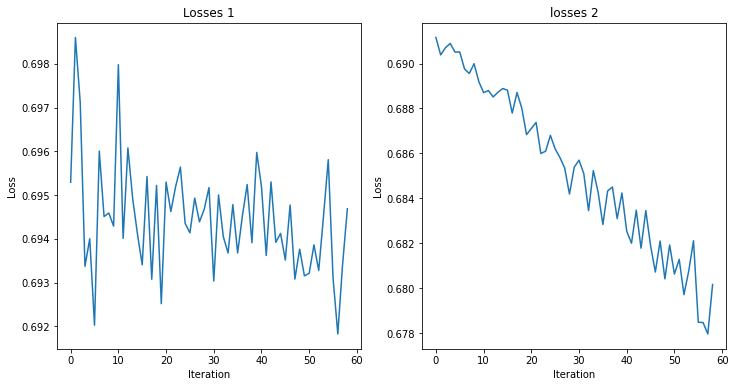

In [27]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
show_loss(losses_1)
plt.title("Losses 1")
plt.subplot(1,2,2)
show_loss(losses_2)
plt.title("losses 2");